# <center>Generating the dataset</center>
---

In [2]:
from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.composition import (
    ElementProperty, 
    Stoichiometry, 
    ValenceOrbital, 
    IonProperty
)
from matminer.featurizers.structure import (
    SiteStatsFingerprint, 
    StructuralHeterogeneity, 
    ChemicalOrdering, 
    StructureComposition, 
    MaximumPackingEfficiency
)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
pd.set_option('display.max_columns', None)

First, I load a snapshot of the [Materials Project](https://materialsproject.org/) database through *matminer*.

In [3]:
mp_all = load_dataset('mp_all')

In [5]:
mp_all.head(5)

,mpid,formula,e_hull,gap pbe,mu_b,elastic anisotropy,bulk modulus,shear modulus,structure,e_form,initial structure
0,mp-85,In,0.003319,0.0000,2.700000e-05,1.044699,33.154748,4.904836,[[0. 0. 0.] In],0.003319,[[0. 0. 0.] In]
1,mp-110,Mg,0.039182,0.0000,-1.360000e-05,-11.326659,35.636106,1.830272,[[0. 0. 0.] Mg],0.039182,[[0. 0. 0.] Mg]
2,mp-20,Be,0.108143,0.0000,1.000000e-07,8.030000,124.000000,84.000000,"[[0.63178657 0.88038073 0.88034747] Be, [1.895...",0.108143,"[[0.71544 1.0248 0.6759 ] Be, [1.79944 2.3912..."
3,mp-8640,Hf,0.071216,0.0000,-2.050000e-05,0.881277,101.242732,44.836516,[[0. 0. 0.] Hf],0.071216,[[0. 0. 0.] Hf]
4,mp-674158,P,3.509988,2.0113,3.000042e+00,10.884643,0.327165,-0.064038,[[0. 0. 0.] P],3.509988,[[0. 0. 0.] P]


Let's take a look at the structure information included in the dataset.

In [14]:
mp_all.loc[1506, 'structure']

Structure Summary
Lattice
    abc : 2.98332041 2.98332041 2.98332041
 angles : 90.0 90.0 90.0
 volume : 26.55215030809569
      A : 2.98332041 0.0 -0.0
      B : 0.0 2.98332041 -0.0
      C : 0.0 0.0 2.98332041
PeriodicSite: Ti (1.4917, 1.4917, 1.4917) [0.5000, 0.5000, 0.5000]
PeriodicSite: Co (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]

For this project, we will use structural features to predict the gap, so let's get rid of the unnecessary data.

In [ ]:
mp_all = mp_all[['gap pbe', 'structure']]

Next, we featurize (see the `README` for more details).

In [15]:
featurizer = MultipleFeaturizer([
    SiteStatsFingerprint.from_preset("CoordinationNumber_ward-prb-2017"),
    StructuralHeterogeneity(),
    ChemicalOrdering(),
    MaximumPackingEfficiency(),
    SiteStatsFingerprint.from_preset("LocalPropertyDifference_ward-prb-2017"),
    StructureComposition(Stoichiometry()),
    StructureComposition(ElementProperty.from_preset("magpie")),
    StructureComposition(ValenceOrbital(props=['frac'])),
    StructureComposition(IonProperty(fast=True))
])

In [ ]:
df = featurizer.featurize_dataframe(mp_all, 'structure', ignore_errors = True)

Note: the above featurization was run on HPC clusters and took several hours. I have included the output as `mp_featurized.csv` in the `data` folder.

In [64]:
df = pd.read_csv('./data/mp_featurized.csv')
df.head(5)

,gap pbe,minimum CN_VoronoiNN,maximum CN_VoronoiNN,range CN_VoronoiNN,mean CN_VoronoiNN,avg_dev CN_VoronoiNN,mean absolute deviation in relative bond length,max relative bond length,min relative bond length,minimum neighbor distance variation,maximum neighbor distance variation,range neighbor distance variation,mean neighbor distance variation,avg_dev neighbor distance variation,mean absolute deviation in relative cell size,mean ordering parameter shell 1,mean ordering parameter shell 2,mean ordering parameter shell 3,max packing efficiency,minimum local difference in Number,maximum local difference in Number,range local difference in Number,mean local difference in Number,avg_dev local difference in Number,minimum local difference in MendeleevNumber,maximum local difference in MendeleevNumber,range local difference in MendeleevNumber,mean local difference in MendeleevNumber,avg_dev local difference in MendeleevNumber,minimum local difference in AtomicWeight,maximum local difference in AtomicWeight,range local difference in AtomicWeight,mean local difference in AtomicWeight,avg_dev local difference in AtomicWeight,minimum local difference in MeltingT,maximum local difference in MeltingT,range local difference in MeltingT,mean local difference in MeltingT,avg_dev local difference in MeltingT,minimum local difference in Column,maximum local difference in Column,range local difference in Column,mean local difference in Column,avg_dev local difference in Column,minimum local difference in Row,maximum local difference in Row,range local difference in Row,mean local difference in Row,avg_dev local difference in Row,minimum local difference in CovalentRadius,maximum local difference in CovalentRadius,range local difference in CovalentRadius,mean local difference in CovalentRadius,avg_dev local difference in CovalentRadius,minimum local difference in Electronegativity,maximum local difference in Electronegativity,range local difference in Electronegativity,mean local difference in Electronegativity,avg_dev local difference in Electronegativity,minimum local difference in NsValence,maximum local difference in NsValence,range local difference in NsValence,mean local difference in NsValence,avg_dev local difference in NsValence,minimum local difference in NpValence,maximum local difference in NpValence,range local difference in NpValence,mean local difference in NpValence,avg_dev local difference in NpValence,minimum local difference in NdValence,maximum local difference in NdValence,range local difference in NdValence,mean local difference in NdValence,avg_dev local difference in NdValence,minimum local difference in NfValence,maximum local difference in NfValence,range local difference in NfValence,mean local difference in NfValence,avg_dev local difference in NfValence,minimum local difference in NValence,maximum local difference in NValence,range local difference in NValence,mean local difference in NValence,avg_dev local difference in NValence,minimum local difference in NsUnfilled,maximum local difference in NsUnfilled,range local difference in NsUnfilled,mean local difference in NsUnfilled,avg_dev local difference in NsUnfilled,minimum local difference in NpUnfilled,maximum local difference in NpUnfilled,range local difference in NpUnfilled,mean local difference in NpUnfilled,avg_dev local difference in NpUnfilled,minimum local difference in NdUnfilled,maximum local difference in NdUnfilled,range local difference in NdUnfilled,mean local difference in NdUnfilled,avg_dev local difference in NdUnfilled,minimum local difference in NfUnfilled,maximum local difference in NfUnfilled,range local difference in NfUnfilled,mean local difference in NfUnfilled,avg_dev local difference in NfUnfilled,minimum local difference in NUnfilled,maximum local difference in NUnfilled,range local difference in NUnfilled,mean local difference in NUnfilled,avg_dev local difference in NUnfilled,minimum local difference in GSvolume_pa,maximum local differenc

# Adding class labels

#### Insulator vs. metal

In [65]:
def group_insulators(gap):
    '''
    Returns 1 if the material is insulating, else returns 0.
    '''
    if gap > 0:
        return 1
    return 0

In [66]:
df['insulator'] = df['gap pbe'].apply(group_insulators)

Let's look at the distribution of insulators and metals.

In [67]:
df['insulator'].value_counts()

1    49386
0    34603
Name: insulator, dtype: int64

Reminder: `1` means *insulator* and `0` means *metal*.

#### Trivial vs. non-trivial topology

Because topology data is not available through the [Materials Project API](https://pymatgen.org/pymatgen.ext.matproj.html), I instead used web scraping. This code generates the data file:
```python
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen

def get_topology(mpID):
    site = 'https://materialsproject.org/materials/{}/'.format(mpID)
    req = Request(site, headers = {'User-Agent': 'Mozilla/5.0'})
    page = urlopen(req)
    soup = BeautifulSoup(page, 'html.parser')
    try:
        classification = str(soup.find_all('div', class_ = 'value')[0]).replace('>','<').split('<')[2].replace('*','')
        return classification
    except:
        return None

with open('mpids', 'r') as file:
    id_list = [line.strip() for line in file.readlines()]

for mp_id in id_list:
    with open('topology_data.csv', 'a') as file:
        file.write(mp_id)
        file.write(', ')
        try:
            file.write(str(get_topology(mp_id)))
        except:
            file.write('ERROR')
        file.write('\n')
```

In [68]:
topology_data = pd.read_csv('./data/topology_data.csv', header = None)

In [69]:
def get_class(word):
    '''
    Categorizes the phrases obtained from web scraping.
    '''
    if word in [' None', ' ERROR']:
        return 'Missing'
    else:
        return word[1:]

In [70]:
df['topology'] = topology_data[1].apply(get_class)

Let's look at the distribution of topologically trivial and non-trivial materials (and data missing from Materials Project).

In [71]:
df['topology'].value_counts()

Missing    63858
trivial     8574
SM          8298
TI          3259
Name: topology, dtype: int64

Reminder: `SM` means *topological semimetal* and `TI` means *topological insulator*. Later on, we will group these together as *non-trivial* for the purpose of classifier 2 and determine metal vs. insulator using classifier 1.

# Remove missing tessellations

We now have a dataframe containing all the relevant inputs (features from *matminer*) and outputs (insulator/metal, trivial/non-trivial topology, and band gap). 

In [72]:
df.head(5)

,gap pbe,minimum CN_VoronoiNN,maximum CN_VoronoiNN,range CN_VoronoiNN,mean CN_VoronoiNN,avg_dev CN_VoronoiNN,mean absolute deviation in relative bond length,max relative bond length,min relative bond length,minimum neighbor distance variation,maximum neighbor distance variation,range neighbor distance variation,mean neighbor distance variation,avg_dev neighbor distance variation,mean absolute deviation in relative cell size,mean ordering parameter shell 1,mean ordering parameter shell 2,mean ordering parameter shell 3,max packing efficiency,minimum local difference in Number,maximum local difference in Number,range local difference in Number,mean local difference in Number,avg_dev local difference in Number,minimum local difference in MendeleevNumber,maximum local difference in MendeleevNumber,range local difference in MendeleevNumber,mean local difference in MendeleevNumber,avg_dev local difference in MendeleevNumber,minimum local difference in AtomicWeight,maximum local difference in AtomicWeight,range local difference in AtomicWeight,mean local difference in AtomicWeight,avg_dev local difference in AtomicWeight,minimum local difference in MeltingT,maximum local difference in MeltingT,range local difference in MeltingT,mean local difference in MeltingT,avg_dev local difference in MeltingT,minimum local difference in Column,maximum local difference in Column,range local difference in Column,mean local difference in Column,avg_dev local difference in Column,minimum local difference in Row,maximum local difference in Row,range local difference in Row,mean local difference in Row,avg_dev local difference in Row,minimum local difference in CovalentRadius,maximum local difference in CovalentRadius,range local difference in CovalentRadius,mean local difference in CovalentRadius,avg_dev local difference in CovalentRadius,minimum local difference in Electronegativity,maximum local difference in Electronegativity,range local difference in Electronegativity,mean local difference in Electronegativity,avg_dev local difference in Electronegativity,minimum local difference in NsValence,maximum local difference in NsValence,range local difference in NsValence,mean local difference in NsValence,avg_dev local difference in NsValence,minimum local difference in NpValence,maximum local difference in NpValence,range local difference in NpValence,mean local difference in NpValence,avg_dev local difference in NpValence,minimum local difference in NdValence,maximum local difference in NdValence,range local difference in NdValence,mean local difference in NdValence,avg_dev local difference in NdValence,minimum local difference in NfValence,maximum local difference in NfValence,range local difference in NfValence,mean local difference in NfValence,avg_dev local difference in NfValence,minimum local difference in NValence,maximum local difference in NValence,range local difference in NValence,mean local difference in NValence,avg_dev local difference in NValence,minimum local difference in NsUnfilled,maximum local difference in NsUnfilled,range local difference in NsUnfilled,mean local difference in NsUnfilled,avg_dev local difference in NsUnfilled,minimum local difference in NpUnfilled,maximum local difference in NpUnfilled,range local difference in NpUnfilled,mean local difference in NpUnfilled,avg_dev local difference in NpUnfilled,minimum local difference in NdUnfilled,maximum local difference in NdUnfilled,range local difference in NdUnfilled,mean local difference in NdUnfilled,avg_dev local difference in NdUnfilled,minimum local difference in NfUnfilled,maximum local difference in NfUnfilled,range local difference in NfUnfilled,mean local difference in NfUnfilled,avg_dev local difference in NfUnfilled,minimum local difference in NUnfilled,maximum local difference in NUnfilled,range local difference in NUnfilled,mean local difference in NUnfilled,avg_dev local difference in NUnfilled,minimum local difference in GSvolume_pa,maximum local differenc

In [73]:
df.shape

(83989, 276)

However, the *matminer* calculation of Voronoi tessellations fails for some structures.

In [74]:
df.isna().sum().sum()

900161

900,161 of the cells have no entry. Let's just remove any row for which the calculation failed.

In [75]:
df.dropna(inplace = True)

In [76]:
df.shape

(76893, 276)

We are left with 76,893 materials, which is still a very rich dataset.

# Training/testing data for classifier 1

In [80]:
y_c1 = df['insulator']
exclude_c1 = ['gap pbe', 'insulator', 'topology']
features_c1 = [column for column in df.columns if column not in exclude_c1]
X_c1 = df[features_c1]
X_train_c1, X_test_c1, y_train_c1, y_test_c1 = train_test_split(X_c1,y_c1,test_size=0.15)

Let's remove correlated features by calculating Pearson coefficients **only on the training set**, so that the test set does not influence the choice of features in any way.

In [83]:
# Create correlation matrix
corr_matrix = X_train_c1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop_c1 = [column for column in upper.columns if any(upper[column] > 0.75)]

In [84]:
X_train_c1 = X_train_c1.drop(X_train_c1[to_drop_c1], axis = 1)
X_test_c1 = X_test_c1.drop(X_test_c1[to_drop_c1], axis = 1)

Let's visualize the correlation heatmap.

<IPython.core.display.Javascript object>


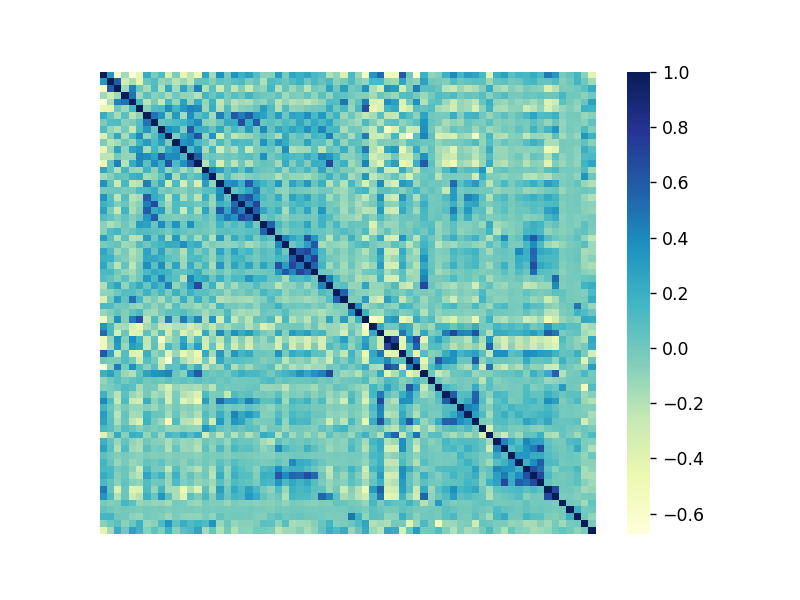

In [89]:
corr = X_train_c1.corr()
plt.figure()
sns.heatmap(corr, xticklabels = False, yticklabels = False, cmap='YlGnBu');

Finally, save the data as CSV files for use in the training jobs (to be submitted to HPC clusters).

In [90]:
X_train_c1.to_csv('./data/X_train_c1.csv', index = False)
y_train_c1.to_csv('./data/y_train_c1.csv', index = False)
X_test_c1.to_csv('./data/X_test_c1.csv', index = False)
y_test_c1.to_csv('./data/y_test_c1.csv', index = False)

# Training/testing data for regressor

Of course, when predicting band gaps, we only need to consider insulators (following the flowchart in the `README`). Therefore, we should only include rows for which the value of `insulator` is `1`.

In [94]:
insulators = df.query('`insulator` == 1')

In [96]:
y_r = insulators['gap pbe']
exclude_r = ['gap pbe', 'insulator', 'topology']
features_r = [column for column in insulators.columns if column not in exclude_r]
X_r = insulators[features_r]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r,y_r,test_size=0.15)

As before, remove features which are correlated in the training set.

In [97]:
corr_matrix = X_train_r.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_r = [column for column in upper.columns if any(upper[column] > 0.75)]

In [98]:
X_train_r = X_train_r.drop(X_train_r[to_drop_r], axis = 1)
X_test_r = X_test_r.drop(X_test_r[to_drop_r], axis = 1)

In [100]:
X_train_r.to_csv('./data/X_train_r.csv', index = False)
y_train_r.to_csv('./data/y_train_r.csv', index = False)
X_test_r.to_csv('./data/X_test_r.csv', index = False)
y_test_r.to_csv('./data/y_test_r.csv', index = False)

# Training/testing data for classifier 2

In [103]:
df['topology'].value_counts()

Missing    57618
trivial     8225
SM          7904
TI          3146
Name: topology, dtype: int64

Since Materials Project is missing a lot of the topological data, we need to sample the dataframe again.

In [105]:
topological = df.query('`topology` != "Missing"')

Additionally, we should group topological semimetals and insulators together as *non-trivial*.

In [112]:
def group_non_trivial(label):
    '''
    Groups topological semimetals and insulators together.
    0 is trivial, 1 is non-trivial.
    '''
    if label == 'trivial':
        return 0
    return 1

In [110]:
topological.loc[:, 'topology'] = topological.loc[:, 'topology'].apply(group_non_trivial)

Lastly, we repeat the same train/test split procedure. This time, we can use the band gap as one of the features because the value can be predicted by the regressor (see README).

In [114]:
y_c2 = topological['topology']
exclude_c2 = ['insulator', 'topology']
features_c2 = [column for column in topological.columns if column not in exclude_c2]
X_c2 = topological[features_c2]
X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(X_c2,y_c2,test_size=0.15)

In [115]:
# Removing features correlated in the training set
corr_matrix = X_train_c2.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_c2 = [column for column in upper.columns if any(upper[column] > 0.75)]
X_train_c2 = X_train_c2.drop(X_train_c2[to_drop_c2], axis = 1)
X_test_c2 = X_test_c2.drop(X_test_c2[to_drop_c2], axis = 1)

In [116]:
X_train_c2.to_csv('./data/X_train_c2.csv', index = False)
y_train_c2.to_csv('./data/y_train_c2.csv', index = False)
X_test_c2.to_csv('./data/X_test_c2.csv', index = False)
y_test_c2.to_csv('./data/y_test_c2.csv', index = False)

This concludes the generation of all datasets needed for the three models. To train each model, the CSV files were copied to an HPC cluster.